# Kaggle Learn: Computer Vision

In this notebook, we teach a computer to see! We will be introduced to the fundamental ideas of computer vision. Our goal is to learn how a neural network can "understand" a natural image well-enough to solve the same kinds of problems the human visual system can solve.

The neural networks that are best at this task are called **convolutional neural networks** (Sometimes we say *convnet* or *CNN* instead.) **Convolution** is the mathematical operation that gives the layers of a convnet their unique structure.

We will apply these ideas to the problem of image classification: given a picture, can we train a computer to tell us what it's a picture of? For example, apps that can identify a species of plant from a photograph are image classifiers!

## Table Of Contents

* **0.** [Dependancies and Settings](#0-Dependancies-and-Settings)  
* **1.** [Useful Links](#1-Useful-Links)  
* **2.** [The Convolutional Classifier](#2-The-Convolutional-Classifier)  
  * **2.1.** [Training a Covnet Classifier](#2.1-Training-a-Covnet-Classifier)  
  * **2.2.** [Linear Units in Keras](#2.2-Linear-Units-in-Keras)   

## 0 Dependancies and Settings

Installation:

In [1]:
# Installing or upgrading
# Note: might have to restart kernel

# Uncomment:
# import sys

# Installing:
# !{sys.executable} -m pip install scikit-learn
# Upgrading:
# !{sys.executable} -m pip install --upgrade scipy==1.9.0 --user

Imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn

In [3]:
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)
print('tensorflow version:', tf.__version__)
print('sci-kit learn version:', sklearn.__version__)

pandas version: 1.5.2
numpy version: 1.23.0
tensorflow version: 2.11.0
sci-kit learn version: 1.2.0


Set the plotting style:

In [4]:
try:
    scientific_style = [
        '../../Random/PythonTutorialsForDataScience/data/science.mplstyle', 
        '../../Random/PythonTutorialsForDataScience/data/notebook.mplstyle', 
        '../../Random/PythonTutorialsForDataScience/data/grid.mplstyle'
    ]

    plt.style.use(scientific_style)
    
    print('Using Scientific Style.')
except:
    print('Missing Scientific Style, continuing with default.')

Using Scientific Style.


Define the filepath where most of the data resides:

In [5]:
path = r'C:\Users\seani\Documents\JupyterNotebooks\Kaggle\KaggleLearn\Assets'

Function used to get names of files in a directory:

In [6]:
import os

def get_files(path):
    '''
    Inputs: a path string
    Returns: a list of names of files in a directory
    '''
    
    files = []
    # search through each item in the directory
    for file in os.listdir(path):
        # check it is a file
        if os.path.isfile(os.path.join(path, file)):
            files.append(file)
    
    return files

The seed used throughout for reproducable randomness:

In [7]:
seed = 1

## 1 Useful Links

- Tensorflow main page: https://www.tensorflow.org/  
- Tensorflow python API: https://www.tensorflow.org/api_docs/python/tf  

## 2 The Convolutional Classifier

A convnet used for image classification consists of two parts: a convolutional **base** and a dense **head**. 

The **base** is used to extract the features from an image. It is formed primarily of layers performing the convolution operation, but often includes other kinds of layers as well. (You'll learn about these in the next lesson.)

The **head** is used to determine the class of the image. It is formed primarily of dense layers, but might include other layers like dropout.

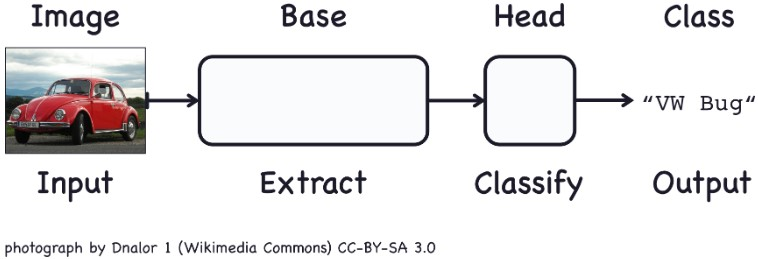

*Figure 1: The Image input is passed through the base and head where features are extracted and classified respectively. These classifications are then used to reach a prediction (output).*

What do we mean by visual **feature**? A feature could be a line, a color, a texture, a shape, a pattern - or some complicated combination.

The whole process goes something like this:

*Note: The features actually extracted look a bit different, but it gives the idea.*

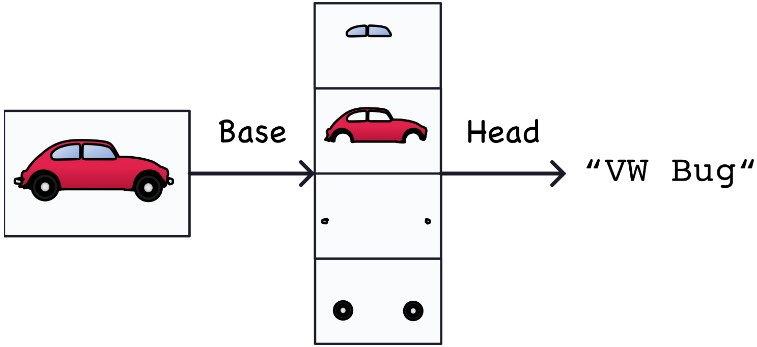

*Figure 2: After the image is passed through the base, it is split into its respective features. After passing through the head, these are classified and a prediction is made.*

The goal of the network during training is to learn two things:

1. Which features to extract from an image (base),
2. Which class goes with what features (head).

These days, convnets are rarely trained from scratch. More often, we reuse the base of a **pretrained model**. To the pretrained base we then attach an untrained head. In other words, we reuse the part of a network that has already learned to extract features (1.), and attach to it some fresh layers to learn classification (2.).

Reusing a pretrained model is a technique known as **transfer learning**. It is so effective, that almost every image classifier these days will make use of it.

### 2.1 Training a Covnet Classifier

Throughout this notebook, we're going to be creating classifiers that attempt to solve the following problem: *is this a picture of a Car or of a Truck?* Our [dataset](https://www.kaggle.com/datasets/ryanholbrook/car-or-truck) is about 10,000 pictures of various automobiles, around half cars and half trucks.

This following cell will import some libraries and set up our data pipeline. We have a training split called ``ds_train`` and a validation split called ``ds_valid``.

In [8]:
# imports
import os, warnings
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory

warnings.filterwarnings("ignore") # to clean up output cells

# reproducability
np.random.seed(seed)
tf.random.set_seed(seed)

# load training and validation sets
ds_train_ = image_dataset_from_directory(
    'Assets/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'Assets/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_train

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

The most commonly used dataset for pretraining is [ImageNet](https://www.image-net.org/download.php), a large dataset of many kind of natural images. Keras includes a variety models pretrained on ImageNet in its [``applications`` module](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

One of the bases we can use is from a model called **VGG16**. However, we would see that the VGG16 architecture is prone to overfitting this dataset. Over this notebook, we'll learn a number of ways we can improve upon this initial attempt.

The first way we'll see is to use a base more appropriate to the dataset. The base this model comes from is called **InceptionV1** (also known as GoogLeNet). InceptionV1 was one of the early winners of the ImageNet competition. One of its successors, InceptionV4, is among the state of the art today.

The InceptionV1 model pretrained on ImageNet is available in the [TensorFlow Hub repository](https://www.tensorflow.org/hub/), but we'll load it from a local copy:

*Note: when doing transfer learning, it's generally not a good idea to retrain the entire base - at least not without some care. The reason is that the random weights in the head will initially create large gradient updates, which propogate back into the base layers and destroy much of the pretraining. Using techniques known as **fine tuning** it's possible to further train the base on new data, but this requires some care to do well.*

In [10]:
pretrained_base = tf.keras.models.load_model(
    'models/inceptionv1'
)

pretrained_base.trainable = False

pretrained_base

Next, we attach the classifier head. For this example, we'll use a layer of hidden units (the first Dense layer) followed by a layer to transform the outputs to a probability score for class 1, Truck. The Flatten layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Base
    pretrained_base,
    layers.Flatten(),  # flatten outputs of base
    # Head
    layers.Dense(units=6, activation='relu'),
    # Output
    layers.Dense(units=1, activation='sigmoid'),
])

Finally, let's train the model. Since this is a two-class problem, we'll use the **binary** versions of ``crossentropy`` and ``accuracy``. The ``adam`` optimizer generally performs well, so we'll choose it as well:

In [14]:
# create optimizer
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

# compile model
model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
)

Epoch 1/30
80/80 [==============================] - 98s 1s/step - loss: 0.5718 - binary_accuracy: 0.6934 - val_loss: 0.4334 - val_binary_accuracy: 0.8074
Epoch 2/30
80/80 [==============================] - 78s 985ms/step - loss: 0.4243 - binary_accuracy: 0.8061 - val_loss: 0.3867 - val_binary_accuracy: 0.8323
Epoch 3/30
80/80 [==============================] - 75s 947ms/step - loss: 0.3886 - binary_accuracy: 0.8304 - val_loss: 0.3704 - val_binary_accuracy: 0.8402
Epoch 4/30
80/80 [==============================] - 76s 952ms/step - loss: 0.3707 - binary_accuracy: 0.8386 - val_loss: 0.3612 - val_binary_accuracy: 0.8454
Epoch 5/30
80/80 [==============================] - 76s 956ms/step - loss: 0.3565 - binary_accuracy: 0.8439 - val_loss: 0.3544 - val_binary_accuracy: 0.8495
Epoch 6/30
80/80 [==============================] - 78s 977ms/step - loss: 0.3458 - binary_accuracy: 0.8478 - val_loss: 0.3480 - val_binary_accuracy: 0.8503
Epoch 7/30
80/80 [==============================] - 77s 974ms

KeyboardInterrupt: 

We can use Pandas to convert this dictionary to a dataframe and plot it with a built-in method:

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

The training loss and validation loss stay fairly close, this is evidence that the model isn't just memorizing the training data but rather learning general properties of the two classes. However, because this model converges at a loss greater than the VGG16 model (test for yourself), it's likely that it is underfitting some, and could benefit from some extra capacity.